In [1]:
!pip install parfit

  Created wheel for parfit: filename=parfit-0.220-py3-none-any.whl size=8659 sha256=8f90ca094c3ae98fcc2548d588df29e4ed1218bd3d57080226353dbf6789db2a
  Stored in directory: /root/.cache/pip/wheels/9a/3b/19/64addee68f796a7e7108c2658a8765d600753bc728e7beb55e
Successfully built parfit


In [2]:
import nltk
from nltk.corpus import wordnet
import pandas as pd
import random
import numpy as np
# import chars2vec
import sklearn.decomposition
import matplotlib.pyplot as plt
import pickle
import string
from sklearn.model_selection import train_test_split #split data into train and test sets
from sklearn.feature_extraction.text import CountVectorizer #convert text comment into a numeric vector
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer #use TF IDF transformer to change text vector created by count vectorizer
from sklearn.svm import SVC, LinearSVC# Support Vector Machine
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import re
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from tensorflow import keras
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU,Conv1D,MaxPooling1D, Flatten, GlobalMaxPooling1D
from keras.models import Model,Sequential, load_model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers


In [ ]:
# from translate import Translator
# translator= Translator(from_lang="german",to_lang="spanish")
# translation = translator.translate("Guten Morgen")
# print(translation)

# Preprocessing Functions

In [3]:
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
    return synonyms
stop = nltk.corpus.stopwords.words('english')

def augment_data(sent):
    words = sent.split()
    words = [w if w not in stop else '@'+w for w in words]
    for i in range(len(words)):
        if not words[i].startswith('@'):
            syn_w = get_synonyms(words[i])
            if syn_w != []:
                w = random.choice(syn_w)
                words[i] = " ".join(w.split('_'))
        else:
            words[i] = words[i][1:]
    return " ".join(words)

def preprocess_text(s):
    s = s.replace('\n',' ')
    s = s.replace('\t',' ')
    s = s.replace(':',' ')
    s = s.replace('#',' ')
    s = s.replace('*','u')
    s = s.replace('@','a')
    s = s.replace('$','s')
    s = s.replace('7','s')
    s = s.replace('2','to')
    s = s.replace('8','ight')
    s = s.replace('&', 'and')
    s = s.translate(str.maketrans('', '', string.punctuation) ) 
    s = s.split()
    s = [i for i in s if i]
    s = [re.sub("[^0-9a-zA-Z]+", "", i) for i in s]
    s = [i for i in s if len(i)>1]
    return " ".join(s)


def transform_x(df):
    x = df.apply(lambda row : preprocess_text(row['comment_text']), axis=1)
    return pd.DataFrame(x,columns=['comment_text'])

def merge(df1,df2):
    return pd.concat([df1, df2], axis=1)


def drop_faulty_rows(df):
    return df.drop(df[(df['toxic'] == -1.0) & (df['severe_toxic'] == -1.0) & 
                    (df['obscene'] == -1.0) & (df['threat'] == -1.0) & 
                    (df['insult'] == -1.0) & (df['identity_hate'] == -1.0) ].index)
    
def combine_labels(train_df):
    x = np.where(train_df['toxic']+train_df['severe_toxic']+train_df['obscene']
             +train_df['threat']+train_df['insult']+train_df['identity_hate'] > 0, 1, 0)
    return pd.DataFrame(x,columns=['Toxic'])
    

# Training Data Transformation

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/NLP_Project_IITB/Project/jigsaw-toxic-comment-classification-challenge/train.csv')

In [ ]:
train_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
X = transform_x(train_df)
X.head()

,comment_text
0,Explanation Why the edits made under my userna...
1,Daww He matches this background colour Im seem...
2,Hey man Im really not trying to edit war Its j...
3,More cant make any real suggestions on improve...
4,You sir are my hero Any chance you remember wh...


In [ ]:
Y = combine_labels(train_df)
Y.head()

,Toxic
0,0
1,0
2,0
3,0
4,0


## Test Data

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/NLP_Project_IITB/Project/jigsaw-toxic-comment-classification-challenge/test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/NLP_Project_IITB/Project/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
y_test.head(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1


In [ ]:
x_test = transform_x(test_df)
df_col_merged = merge(x_test,y_test)
df_col_merged.head()

,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Yo bitch Ja Rule is more succesful then youll ...,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,From RfC The title is fine as it is IMO,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,Sources Zawe Ashton on Lapland,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,If you have look back at the source the inform...,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,dont anonymously edit articles at all,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
test_df = drop_faulty_rows(df_col_merged)

In [ ]:
x_test = test_df['comment_text']
y_test = combine_labels(test_df)

Feature transformation

In [ ]:
tokenizer = Tokenizer(char_level=True, lower=False)

In [ ]:
tokenizer.fit_on_texts(X.comment_text)

In [ ]:
len(tokenizer.index_word)

60

In [ ]:
# pickle.dump(tokenizer,open('/content/drive/MyDrive/NLP_Project_IITB/Project/jigsaw-toxic-comment-classification-challenge/data/tokenizer.pkl','wb'))

In [ ]:
maxlen = 500

In [ ]:
X_comment = pad_sequences(tokenizer.texts_to_sequences(X.comment_text), maxlen=
                          maxlen,padding='post')

In [ ]:
x_test_tokenized = tokenizer.texts_to_sequences(x_test)
maxlen = 500
x_test = pad_sequences(x_test_tokenized, maxlen=
                          maxlen,padding='post')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X.comment_text, Y, test_size=.2, random_state=42)

OverSampling using Data Augmentation

In [ ]:
def augment_sentences(X,Y):
    maxlen = 15
    maxiter = 100
    augmented_sent = []
    X = X.to_numpy()
    Y = Y.to_numpy().ravel()
    X = X[Y==1]
    for comment in X:
        varied_sent = set()
        itr = 0
        while(len(varied_sent)<maxlen and itr < maxiter):
                varied_sent.add(augment_data(comment))
                itr += 1
        augmented_sent.extend([s for s in varied_sent])
        
    return augmented_sent

def sample_sent(sents, sample_size):
    return random.choices(sents, k=sample_size)

sample_size = 50000
aug_sent = augment_sentences(X_train, y_train)
augmented_sampled_sent = sample_sent(aug_sent, sample_size)

To do oversampling uncomment

In [ ]:
# X_train = np.hstack((X_train.to_numpy(),np.array(augmented_sampled_sent)))
# y_train = np.hstack((y_train.to_numpy().ravel(), [1 for _ in range(sample_size)]))

In [ ]:
tokenized_sent_list = tokenizer.texts_to_sequences(X_train)

In [ ]:
import statistics

print("Mean length of sentence:",statistics.mean([len(s) for s in tokenized_sent_list]))
print("Median length of sentence:",statistics.median([len(s) for s in tokenized_sent_list]))
print("Mode length of sentence:",statistics.mode([len(s) for s in tokenized_sent_list]))
print("Max length of sentence:",max([len(s) for s in tokenized_sent_list]))

Mean length of sentence: 370.5989926051263
Median length of sentence: 191.0
Mode length of sentence: 32
Max length of sentence: 5077


In [ ]:
X_train = pad_sequences(tokenized_sent_list, maxlen=
                          maxlen,padding='post')

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
X_train.shape

(127656, 500)

In [ ]:
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=
                          maxlen,padding='post')
y_val = y_val.to_numpy().ravel()

In [ ]:
X_val.shape

(31915, 500)

## Neural Network

In [ ]:
'''
Model 1

Imitates SVM using Neural Network
'''
# embed_size = 300
# model = Sequential(name="text_feature_extractor")
# model.add(Embedding(len(tokenizer.word_index)+1, embed_size, input_length=maxlen, name="embedding"))
# model.add(Conv1D(filters=100,kernel_size=10,name="conv1D", activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=4, name="max_pool"))
# model.add(Flatten(name="flatten"))
# model.add(Dense(512, name="dense1", activation='relu'))
# model.add(Dropout(0.5, name='dropout'))
# model.add(Dense(1,name="dense_final_reg", kernel_regularizer=l2(0.0001), activation='tanh' ) )

# model.compile(loss='hinge',
#               optimizer='adam',
#               metrics=['accuracy'])
# model.summary()

'''
Model 2
'''
# n_classes = 2
# embed_size = 300
# num_filters = 64
# weight_decay = 1e-4

# model = Sequential(name="text_feature_extractor")
# model.add(Embedding(len(tokenizer.word_index)+1, embed_size, input_length=maxlen, name="embedding"))
# model.add(Conv1D(num_filters, 7, activation='relu', padding='same', name="conv1D_1"))
# model.add(MaxPooling1D(2, name="max_pool") )
# model.add(Conv1D(num_filters, 7, activation='relu', padding='same', name="conv1D_2"))
# model.add(GlobalMaxPooling1D( name="global_max_pool"))
# model.add(Dropout(0.5, name='dropout'))
# model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay),name="dense_1"))
# model.add(Dense(n_classes, activation='tanh', name='dense_final'))
# model.compile(loss='hinge',
#               optimizer='adam',
#               metrics=['accuracy'])
# model.summary()

'''
Model 3
performs the best 
'''
embed_size = 300
model = Sequential(name="Model-Binary-loss")
model.add(Embedding(len(tokenizer.word_index)+1, embed_size, input_length=maxlen, name="embedding"))
model.add(Conv1D(filters=100,kernel_size=10,name="conv1D", activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=4, name="max_pool"))
model.add(Flatten(name="flatten"))
model.add(Dense(512, name="dense1", activation='relu'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(1,name="dense_final_reg", kernel_regularizer=l2(0.0001), activation='sigmoid' ) )

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "Model-Binary-loss"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          18300     
                                                                 
 conv1D (Conv1D)             (None, 500, 100)          300100    
                                                                 
 max_pool (MaxPooling1D)     (None, 125, 100)          0         
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 dense1 (Dense)              (None, 512)               6400512   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_final_reg (Dense)     (None, 1)           

### Model 3

In [ ]:
filepath="/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep{epoch:03d}-loss{loss:.3f}-acc{accuracy:.3f}-val_loss{val_loss:.3f}-val_acc{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

# train the model
history = model.fit(
    X_train, 
    y_train,
    class_weight = {0:0.1,1:0.9},
    epochs=5, 
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks = [checkpoint]
)

Epoch 1/5
1995/1995 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.8334
Epoch 00001: val_accuracy improved from -inf to 0.84822, saving model to /content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep001-loss0.082-acc0.833-val_loss0.412-val_acc0.848.hdf5
1995/1995 [==============================] - 107s 49ms/step - loss: 0.0820 - accuracy: 0.8334 - val_loss: 0.4122 - val_accuracy: 0.8482
Epoch 2/5
1995/1995 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.8762
Epoch 00002: val_accuracy improved from 0.84822 to 0.90431, saving model to /content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep002-loss0.062-acc0.876-val_loss0.301-val_acc0.904.hdf5
1995/1995 [==============================] - 101s 50ms/step - loss: 0.0622 - accuracy: 0.8762 - val_loss: 0.3014 - val_accuracy: 0.9043
Epoch 3/5
1994/1995 [============================>.] - ETA: 0s - loss: 0.0520 - accuracy: 0.8965
Ep

In [ ]:
history2 = model.fit(
    X_train, 
    y_train,
    class_weight = {0:0.1,1:0.9},
    epochs=10, 
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks = [checkpoint]
)

Epoch 1/10
1994/1995 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9489
Epoch 00001: val_accuracy did not improve from 0.91734
1995/1995 [==============================] - 100s 50ms/step - loss: 0.0275 - accuracy: 0.9489 - val_loss: 0.2646 - val_accuracy: 0.9112
Epoch 2/10
1995/1995 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9585
Epoch 00002: val_accuracy improved from 0.91734 to 0.91800, saving model to /content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep002-loss0.024-acc0.958-val_loss0.246-val_acc0.918.hdf5
1995/1995 [==============================] - 100s 50ms/step - loss: 0.0240 - accuracy: 0.9585 - val_loss: 0.2463 - val_accuracy: 0.9180
Epoch 3/10
1995/1995 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9664
Epoch 00003: val_accuracy improved from 0.91800 to 0.92292, saving model to /content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gp

In [ ]:
history3 = model.fit(
    X_train, 
    y_train,
    class_weight = {0:0.1,1:0.9},
    epochs=10, 
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks = [checkpoint]
)

Epoch 1/10
1995/1995 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9836
Epoch 00001: val_accuracy did not improve from 0.93216
1995/1995 [==============================] - 95s 48ms/step - loss: 0.0138 - accuracy: 0.9836 - val_loss: 0.2912 - val_accuracy: 0.9277
Epoch 2/10
1995/1995 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9851
Epoch 00002: val_accuracy improved from 0.93216 to 0.93373, saving model to /content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep002-loss0.013-acc0.985-val_loss0.277-val_acc0.934.hdf5
1995/1995 [==============================] - 95s 48ms/step - loss: 0.0133 - accuracy: 0.9851 - val_loss: 0.2768 - val_accuracy: 0.9337
Epoch 3/10
1994/1995 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9845
Epoch 00003: val_accuracy did not improve from 0.93373
1995/1995 [==============================] - 96s 48ms/step - loss: 0.0138 - accuracy: 0.9846 - val_loss: 0.

### Model 1

In [ ]:
filepath="/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/over-sampled-text_feature_extractor-ep{epoch:03d}-loss{loss:.3f}-acc{accuracy:.3f}-val_loss{val_loss:.3f}-val_acc{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

# train the model
history = model.fit(
    X_train, 
    y_train,
    epochs=5, 
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks = [checkpoint]
)

Epoch 1/5
2776/2776 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.6455
Epoch 00001: val_accuracy improved from -inf to 0.89836, saving model to /content/drive/MyDrive/NLP_Project_IITB/Project/training_models/over-sampled-text_feature_extractor-ep001-loss0.709-acc0.645-val_loss0.203-val_acc0.898.hdf5
2776/2776 [==============================] - 126s 45ms/step - loss: 0.7091 - accuracy: 0.6455 - val_loss: 0.2033 - val_accuracy: 0.8984
Epoch 2/5
2776/2776 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.6459
Epoch 00002: val_accuracy did not improve from 0.89836
2776/2776 [==============================] - 124s 45ms/step - loss: 0.7083 - accuracy: 0.6459 - val_loss: 0.2033 - val_accuracy: 0.8984
Epoch 3/5
2776/2776 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.6455
Epoch 00003: val_accuracy did not improve from 0.89836
2776/2776 [==============================] - 124s 45ms/step - loss: 0.7091 - accuracy: 0.6455 - v

### Plots of Model 3 training

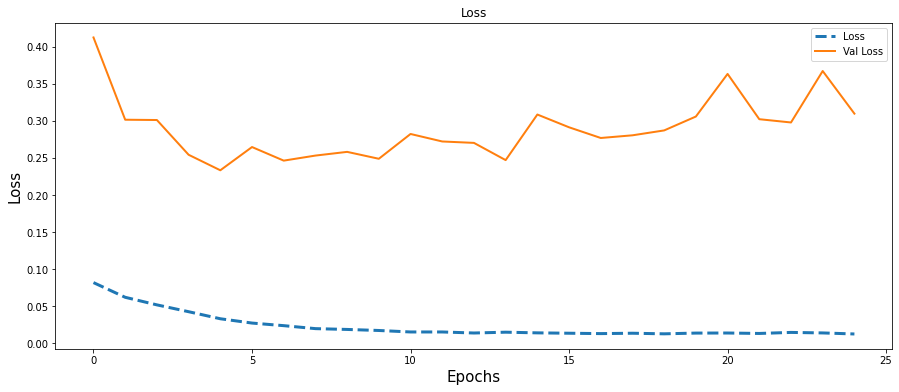

In [ ]:
loss = [0.082, 0.0622, 0.052, 0.0428, 0.0333, 0.0275, 0.024, 0.02, 0.0189, 0.0175, 0.0155, 0.0155, 0.0141, 0.0152, 0.0143, 0.0138, 0.0133, 0.0138, 0.013, 0.014, 0.0141, 0.0135, 0.0149, 0.0142, 0.0128]

val_loss = [0.4122, 0.3014, 0.301, 0.2542, 0.2333, 0.2646, 0.2463, 0.2531, 0.2581, 0.2488, 0.2822, 0.2721, 0.2702, 0.247, 0.3084, 0.2912, 0.2768, 0.2804, 0.287, 0.3057, 0.3631, 0.3021, 0.2977, 0.367, 0.3096]

plt.figure(figsize=(15, 6))
plt.plot(loss, lw =3, ls = '--', label = 'Loss')
plt.plot(val_loss, lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Loss')
plt.legend()

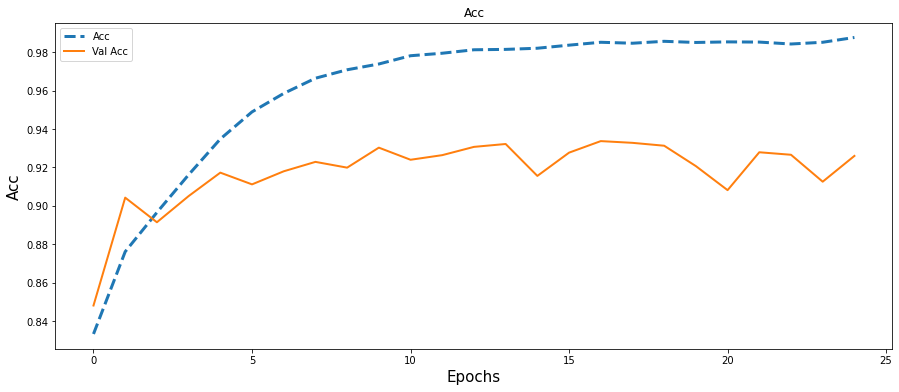

In [ ]:
acc = [0.8334, 0.8762, 0.8966, 0.9162, 0.9348, 0.9489, 0.9585, 0.9664, 0.9708, 0.9738, 0.9781, 0.9794, 0.9812, 0.9814, 0.982, 0.9836, 0.9851, 0.9846, 0.9856, 0.985, 0.9853, 0.9852, 0.9842, 0.9851, 0.9876]

val_acc = [0.8482, 0.9043, 0.8915, 0.9051, 0.9173, 0.9112, 0.918, 0.9229, 0.9199, 0.9303, 0.924, 0.9264, 0.9307, 0.9322, 0.9156, 0.9277, 0.9337, 0.9328, 0.9313, 0.9207, 0.9082, 0.9279, 0.9266, 0.9126, 0.926]
plt.figure(figsize=(15, 6))
plt.plot(acc, lw =3, ls = '--', label = 'Acc')
plt.plot(val_acc, lw =2, ls = '-', label = 'Val Acc')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Acc', fontsize=15)
plt.title('Acc')
plt.legend()

## Parfit SGD Hyperparameter tuning

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 11.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    2.3s finished


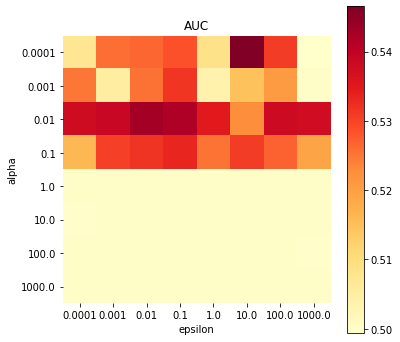

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'loss': ['hinge'], 
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

# bestModel, bestScore, allModels, allScores -> all_tuples
all_tuples = pf.bestFit(SGDClassifier, paramGrid,
           X_train, y_train, X_val, y_val, 
           metric = roc_auc_score,
           scoreLabel = "AUC")

# print(bestModel, bestScore)
# pickle.dump(all_tuples,open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/all_tuples_SGD_parfit.pkl','wb'))

Fine tuning coarse range hyperparameter

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 48.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 56.2min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 64.6min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 71.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed: 76

-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 130 out of 133 | elapsed:    4.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:    4.6s finished


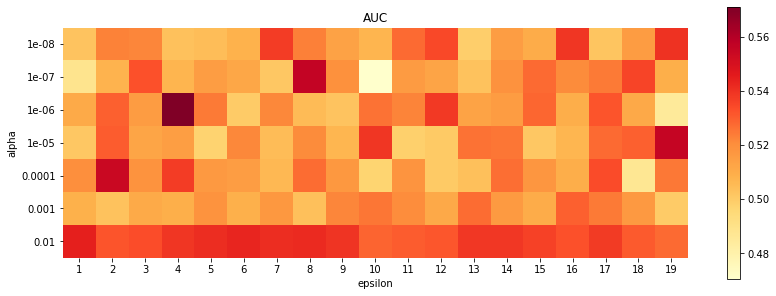

In [ ]:

grid = {
    'alpha': [1e-8,1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2], # learning rate
    'epsilon': [i for i in range(1,20)],
    'loss': ['hinge'], 
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

# bestModel, bestScore, allModels, allScores -> all_tuples
all_tuples = pf.bestFit(SGDClassifier, paramGrid,
           X_train, y_train, X_val, y_val, 
           metric = roc_auc_score,
           scoreLabel = "AUC")

# print(bestModel, bestScore)
# pickle.dump(all_tuples,open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/all_tuples_SGD_parfit_finer.pkl','wb'))

# Online SVM

## Intermediate Layer Feature extractor
Pickle one of the model & layer cell below and then make extractor for it us extractor cell, fit the model, save it. (do one extractor at a time only and repeat for different model & layer cell combination)

Model 1

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/text_feature_extractor-ep003-loss0.202-acc0.899-val_loss0.202-val_acc0.899.hdf5')
layer_name = "flatten"

Oversampled model 1

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/over-sampled-text_feature_extractor-ep001-loss0.709-acc0.645-val_loss0.203-val_acc0.898.hdf5')
layer_name = 'flatten'

Model 2

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/conv2_text_feature_extractor-ep004-loss0.203-acc0.896-val_loss0.203-val_acc0.898.hdf5')
layer_name = 'global_max_pool' # or 'dense_1' or whichever layer you want to try not good results

Model 3

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep002-loss0.013-acc0.985-val_loss0.277-val_acc0.934.hdf5')
layer_name = "flatten"

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep002-loss0.013-acc0.985-val_loss0.277-val_acc0.934.hdf5')
layer_name = "conv1D"

Extractor

In [ ]:
extractor = Model(inputs=model.inputs,
                        outputs=model.get_layer(layer_name).output)
features = extractor(X_comment[:3])
features

<tf.Tensor: shape=(3, 12500), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

No training only layers\
! no improvement

In [ ]:
layers = [Embedding(vocab_size, 256, input_length=maxlen), Conv1D(filters=100,kernel_size=4, activation='relu')]

def feature_extractor(x):
    global layers
    for layer in layers:
        x = layer(x)
    return x

## Fit Model

In [ ]:
from sklearn.kernel_approximation import Nystroem
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1, n_components=1000)

In [ ]:
def randomly_sample_n(x,y,n):
    left = (len(y) - (len(y)//n)*n)
    if left:
        left = n - left
        indices = np.random.choice(y.shape[0], left, replace=False)
        x = np.vstack((x,x[indices]))
        y = np.hstack((y,y[indices]))
    return x,y

In [ ]:
def custom_fit(clf, X, y, classes, batch_size = 32, feature_extractor = None, shuffle=False, checkpoint_step=0, random_state=None, kernel_approximation=None, reshapeLayer=None):

    if shuffle:
        if random_state is not None:
            np.random.seed(random_state)
        randomize = np.arange(len(y))
        np.random.shuffle(randomize)
        X = X[randomize]
        y = y[randomize]

    def batch(iterable, n=1):
        l = len(iterable)
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]
    i = 0

    for batch_range in batch(range(0, len(y)), batch_size):
        i += 1
        if feature_extractor is not None:
            X_b = feature_extractor(X[batch_range.start:batch_range.stop]).numpy()
            if kernel_approximation is not None:
                X_b = feature_map_nystroem.fit_transform(X_b) 
            '''
            reshape if extractor is gives more than 2 dims (like in conv1d)
            '''
            if reshapeLayer is not None:
                X_b = X_b.reshape(X_b.shape[0], -1)
        else:
            X_b = X[batch_range.start:batch_range.stop]
        y_b = y[batch_range.start:batch_range.stop]

        clf.partial_fit(X_b,y_b, classes=classes)
        '''
        Uncomment below to enable checkpointing
        '''
        # if checkpoint_step > 0:
        #     if i%checkpoint_step == 0:
        #         pickle.dump(clf, open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-{}.pkl'.format(i),'wb'))
        #         print("Checkpointed till {}".format(batch_range.stop))
    
    '''
    Save final model
    '''
    # pickle.dump(clf, open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-final.pkl','wb'))
    return clf


Model 1 Flatten Extractor

In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, max_iter=3000, tol=None, shuffle=True, verbose=0, learning_rate='constant', eta0=0.01, early_stopping=False)
classes = Y.Toxic.unique()
online_svm = custom_fit(clf, X_comment, Y.to_numpy().ravel(),classes, batch_size=1024, shuffle=True, random_state=42, feature_extractor=extractor)
# pickle.dump(online_svm, open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model1-no-kernel-extractor-flatten.pkl','wb'))

Model 1 Oversampled - Flatten Extractor

In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, max_iter=3000, tol=None, shuffle=True, verbose=0, learning_rate='constant', eta0=0.01, early_stopping=False)
classes = Y.Toxic.unique()
online_svm = custom_fit(clf, X_comment, Y.to_numpy().ravel(),classes, batch_size=1024, shuffle=True, random_state=42, feature_extractor=extractor)
# pickle.dump(online_svm, open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model1-oversampled-no-kernel-extractor-flatten.pkl','wb'))

Model 1 Oversampled with Kernel

In [ ]:
x_train_sampled, y_train_sampled = randomly_sample_n(X_comment,Y.to_numpy().ravel(),1000)
clf = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, max_iter=3000, tol=None, shuffle=True, verbose=0, learning_rate='constant', eta0=0.01, early_stopping=False)
classes = Y.Toxic.unique()
online_svm = custom_fit(clf, x_train_sampled, y_train_sampled,classes, batch_size=1000, shuffle=True, random_state=42, feature_extractor=extractor, kernel_approximation=True)
# pickle.dump(online_svm, open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model1-oversampled-with-kernel-extractor-flatten.pkl','wb'))

Model 3 - Flatten Extractor

In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, max_iter=3000, tol=None, shuffle=True, verbose=0, learning_rate='constant', eta0=0.01, early_stopping=False)
classes = Y.Toxic.unique()
online_svm = custom_fit(clf, X_comment, Y.to_numpy().ravel(),classes, batch_size=1024, shuffle=True, random_state=42, feature_extractor=extractor)
# pickle.dump(online_svm, open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model3-extractor-flatten.pkl','wb'))

Model 3- conv1D Extractor

In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, max_iter=3000, tol=None, shuffle=True, verbose=0, learning_rate='constant', eta0=0.01, early_stopping=False)
classes = Y.Toxic.unique()
online_svm = custom_fit(clf, X_comment, Y.to_numpy().ravel(),classes, batch_size=1024, shuffle=True, random_state=42, feature_extractor=extractor, reshapeLayer=True)
# pickle.dump(online_svm, open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model3-extractor-conv1D.pkl','wb'))

Model 3 try above best one with kernel: Flatten Layer Extractor Found to be better

In [ ]:
x_train_sampled, y_train_sampled = randomly_sample_n(X_comment,Y.to_numpy().ravel(),1000)
clf = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, max_iter=3000, tol=None, shuffle=True, verbose=0, learning_rate='constant', eta0=0.01, early_stopping=False)
classes = Y.Toxic.unique()
online_svm = custom_fit(clf, x_train_sampled, y_train_sampled,classes, batch_size=1000, shuffle=True, random_state=42, feature_extractor=extractor, kernel_approximation=True)
pickle.dump(online_svm, open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model3-with-kernel-extractor-flatten.pkl','wb'))

# Testing on Model

In [ ]:
def custom_predict(classifier, x_t, batch_size=32, extractor=None, kernel_approximation=None, reshapeLayer=None):
    y_pred = np.array([])
    def pred_batch(iterable, n=1):
        l = len(iterable)
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]
    i = 0
    for batch_range in pred_batch(range(0, len(x_t)), batch_size):
        if extractor is not None:
            x_t_b = extractor(x_t[batch_range.start: batch_range.stop]).numpy()
            if kernel_approximation is not None:
                x_t_b = feature_map_nystroem.fit_transform(x_t_b)
            '''
            reshape if extractor is gives more than 2 dims (like in conv1d)
            '''
            if reshapeLayer is not None:
                x_t_b = x_t_b.reshape(x_t_b.shape[0],-1)
        else:
            x_t_b = x_t[batch_range.start: batch_range.stop]
        y_t = classifier.predict(x_t_b)
        y_pred = np.hstack((y_pred,y_t)).ravel()
    return y_pred

In [ ]:
tokenizer = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/jigsaw-toxic-comment-classification-challenge/data/tokenizer.pkl','rb'))
maxlen = 500
# for samples < n_components of kernel approximation Nystroem cannot be done
def prediction(model, sent, extractor, reshapeLayer=None):
    sents = pad_sequences(tokenizer.texts_to_sequences([sent]), maxlen=
                          maxlen,padding='post')
    sent_pred = custom_predict(model, sents, extractor=extractor, reshapeLayer = reshapeLayer)
    if sent_pred[0] == 1: return 'Toxic'
    return 'Non-Toxic'

Model 1-Flatten

Give toxic sentence below

In [ ]:
inp_sent = "----give toxic sentence here-----"

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/text_feature_extractor-ep003-loss0.202-acc0.899-val_loss0.202-val_acc0.899.hdf5')
layer_name = "flatten"
extractor = Model(inputs=model.inputs,
                        outputs=model.get_layer(layer_name).output)
model1_flatten = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model1-no-kernel-extractor-flatten.pkl','rb'))
model1_flatten_res = prediction(model1_flatten, inp_sent, extractor=extractor)
model1_flatten_res

'Non-Toxic'

Model 1 -Oversampled

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/over-sampled-text_feature_extractor-ep001-loss0.709-acc0.645-val_loss0.203-val_acc0.898.hdf5')
layer_name = 'flatten'
extractor = Model(inputs=model.inputs,
                        outputs=model.get_layer(layer_name).output)
model1_oversampled_flatten = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model1-oversampled-no-kernel-extractor-flatten.pkl','rb'))
model1_oversampled_flatten_res = prediction(model1_oversampled_flatten, inp_sent, extractor=extractor)
model1_oversampled_flatten_res

'Non-Toxic'

Model 3-Flatten

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep002-loss0.013-acc0.985-val_loss0.277-val_acc0.934.hdf5')
layer_name = "flatten"
extractor = Model(inputs=model.inputs,
                        outputs=model.get_layer(layer_name).output)
model3_flatten = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model3-extractor-flatten.pkl','rb'))
model3_flatten_res = prediction(model3_flatten, inp_sent, extractor=extractor)
model3_flatten_res

'Toxic'

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep002-loss0.013-acc0.985-val_loss0.277-val_acc0.934.hdf5')
layer_name = "conv1D"
extractor = Model(inputs=model.inputs,
                        outputs=model.get_layer(layer_name).output)
model3_conv1d =  pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model3-extractor-conv1D.pkl','rb'))
model3_conv1d_res = prediction(model3_conv1d, inp_sent, extractor=extractor, reshapeLayer=True)
model3_conv1d_res

'Toxic'

SGD

In [ ]:
tokenizer = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/jigsaw-toxic-comment-classification-challenge/data/tokenizer.pkl','rb'))
maxlen = 500
# for samples < n_components of kernel approximation Nystroem cannot be done
def sgd_prediction(model, sent):
    sents = pad_sequences(tokenizer.texts_to_sequences([sent]), maxlen=
                          maxlen,padding='post')
    res = model.predict(sents)
    if res[0] == 1: return 'Toxic'
    return 'Non-Toxic'

In [ ]:
sgd_clf = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgd_no-oversampling.pkl','rb'))
sgd_clf_res = sgd_prediction(sgd_clf, inp_sent)
sgd_clf_res

'Non-Toxic'

In [ ]:
sgd_clf_oversample = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgd_oversampled.pkl','rb'))
sgd_clf_oversample_res = sgd_prediction(sgd_clf_oversample, inp_sent)
sgd_clf_oversample_res

'Non-Toxic'

Classification Report

Model 1 SGD

In [ ]:
online_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model1-no-kernel-extractor-flatten.pkl','rb'))

In [ ]:
y_pred = custom_predict(online_svm, x_test,batch_size=1024, extractor=extractor)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.93     57735
           1       0.18      0.07      0.10      6243

    accuracy                           0.88     63978
   macro avg       0.54      0.52      0.52     63978
weighted avg       0.84      0.88      0.85     63978



Model 1 Oversampled SGD

In [ ]:
online_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model1-oversampled-no-kernel-extractor-flatten.pkl','rb'))

In [ ]:
y_pred = custom_predict(online_svm, x_test,batch_size=1024, extractor=extractor)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     57735
           1       0.47      0.10      0.16      6243

    accuracy                           0.90     63978
   macro avg       0.69      0.54      0.55     63978
weighted avg       0.87      0.90      0.87     63978



Model 1 Oversampled with kernel SGD

In [ ]:
online_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model1-oversampled-with-kernel-extractor-flatten.pkl','rb'))

In [ ]:
x_test1, y_test1 = randomly_sample_n(x_test,y_test.to_numpy().ravel(),1000)

In [ ]:
y_pred = custom_predict(online_svm, x_test1, batch_size=1000, extractor=extractor, kernel_approximation=True)
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     57757
           1       0.00      0.00      0.00      6243

    accuracy                           0.90     64000
   macro avg       0.45      0.50      0.47     64000
weighted avg       0.81      0.90      0.86     64000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 3 SGD-flatten layer extractor

In [ ]:
online_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model3-extractor-flatten.pkl','rb'))

In [ ]:
y_pred = custom_predict(online_svm, x_test,batch_size=1024, extractor=extractor)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     57735
           1       0.47      0.63      0.54      6243

    accuracy                           0.89     63978
   macro avg       0.71      0.78      0.74     63978
weighted avg       0.91      0.89      0.90     63978



Model 3 SGD- conv1D layer extractor

In [ ]:
online_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model3-extractor-conv1D.pkl','rb'))

In [ ]:
y_pred = custom_predict(online_svm, x_test,batch_size=1024, extractor=extractor, reshapeLayer=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     57735
           1       0.47      0.59      0.52      6243

    accuracy                           0.90     63978
   macro avg       0.71      0.76      0.73     63978
weighted avg       0.91      0.90      0.90     63978



Model 3 SGD-Flatten Extractor with kernel

In [ ]:
online_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/svm-sgd-model3-with-kernel-extractor-flatten.pkl','rb'))

In [ ]:
x_test1, y_test1 = randomly_sample_n(x_test,y_test.to_numpy().ravel(),1000)

In [ ]:
y_pred = custom_predict(online_svm, x_test1, batch_size=1000, extractor=extractor, kernel_approximation=True)
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     57757
           1       0.00      0.00      0.00      6243

    accuracy                           0.90     64000
   macro avg       0.45      0.50      0.47     64000
weighted avg       0.81      0.90      0.86     64000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM NN

Model 1

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/text_feature_extractor-ep003-loss0.202-acc0.899-val_loss0.202-val_acc0.899.hdf5')

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred = y_pred[:,1]
y_pred[y_pred==-1] = 0

In [ ]:
y_pred = y_pred.round()

In [ ]:
print(classification_report(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.90      1.00      0.95     57735
         1.0       0.64      0.01      0.02      6243

    accuracy                           0.90     63978
   macro avg       0.51      0.34      0.32     63978
weighted avg       0.88      0.90      0.86     63978



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 3

In [ ]:
model = load_model('/content/drive/MyDrive/NLP_Project_IITB/Project/training_models/Model-Binary-loss-gpu-ep002-loss0.013-acc0.985-val_loss0.277-val_acc0.934.hdf5')

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1

In [ ]:
print(classification_report(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     57735
           1       0.50      0.69      0.58      6243

    accuracy                           0.90     63978
   macro avg       0.73      0.81      0.76     63978
weighted avg       0.92      0.90      0.91     63978



## SGD Classifier

In [ ]:
# epsilon, alpha hyperparameter tuned

sgd_clf = SGDClassifier(loss='hinge', penalty='l2', epsilon=4, alpha=1e-6)
# sgd_clf.fit(np.vstack((X_train,X_val)),np.hstack((y_train, y_val)))

SGDClassifier(alpha=1e-06, epsilon=4)

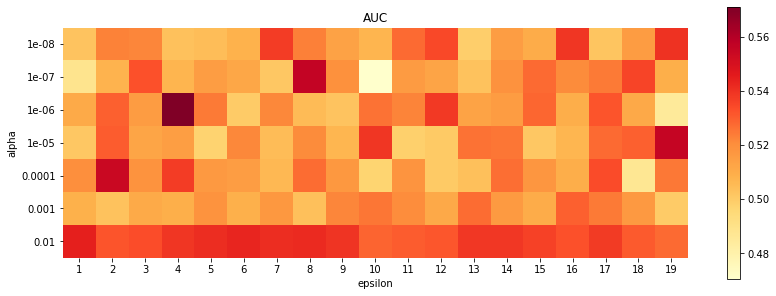

In [ ]:
sgd_clf = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgd_oversampled.pkl','rb'))

With oversampling

In [ ]:
# sgd_clf = SGDClassifier(loss='hinge', penalty='l2', epsilon=4, alpha=1e-6)
# sgd_clf.fit(np.vstack((X_train,X_val)),np.hstack((y_train, y_val)))

In [ ]:
y_pred = sgd_clf.predict(x_test)
print(classification_report(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82     57735
           1       0.14      0.39      0.20      6243

    accuracy                           0.70     63978
   macro avg       0.53      0.56      0.51     63978
weighted avg       0.84      0.70      0.76     63978



With no oversampling

In [ ]:
sgd_clf = SGDClassifier(loss='hinge', penalty='l2', epsilon=4, alpha=1e-6)
sgd_clf.fit(X_comment,Y.to_numpy().ravel())

SGDClassifier(alpha=1e-06, epsilon=4)

In [ ]:
sgd_clf = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgd_no-oversampling.pkl','rb'))

In [ ]:
y_pred = sgd_clf.predict(x_test)
print(classification_report(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     57735
           1       0.20      0.03      0.05      6243

    accuracy                           0.89     63978
   macro avg       0.55      0.51      0.50     63978
weighted avg       0.84      0.89      0.86     63978

